## Project Setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 14.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 17.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 918.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 24.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

2025-08-12 08:49:45.094982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754988585.329953      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754988585.395283      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import random

SEED = 42
def set_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Get the data

Data Source: [The Food-101 Dataset]('https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/')

Contains 101 food categories with 101'000 images.

For this project:
- Start with 3 food classes (pizza, steak, sushi)
- Start with a random 10% of images per class

In [3]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """
    Downloads a zipped dataset from source and unzips to destination.
    """

    # define path at which data will be saved
    data_path = Path("data/")
    image_path = data_path / destination

    # only download image zip file if not already existing on path
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # download zip file
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # unzip zip file
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/pizza/2800325.jpg
Image class: pizza
Image height: 512
Image width: 512


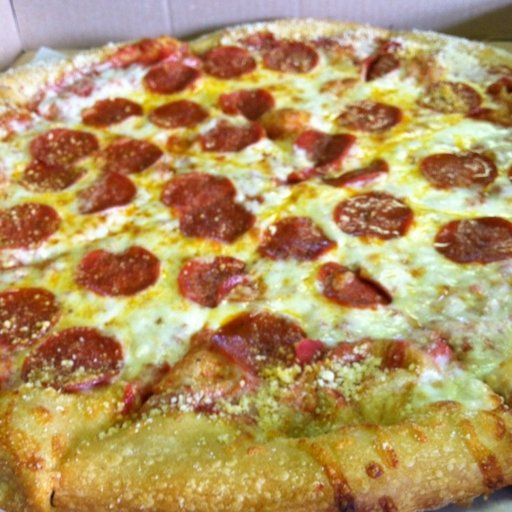

In [19]:
# Visualise a random image

from PIL import Image

# Set seed
random.seed(16)

# Pick a random image
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

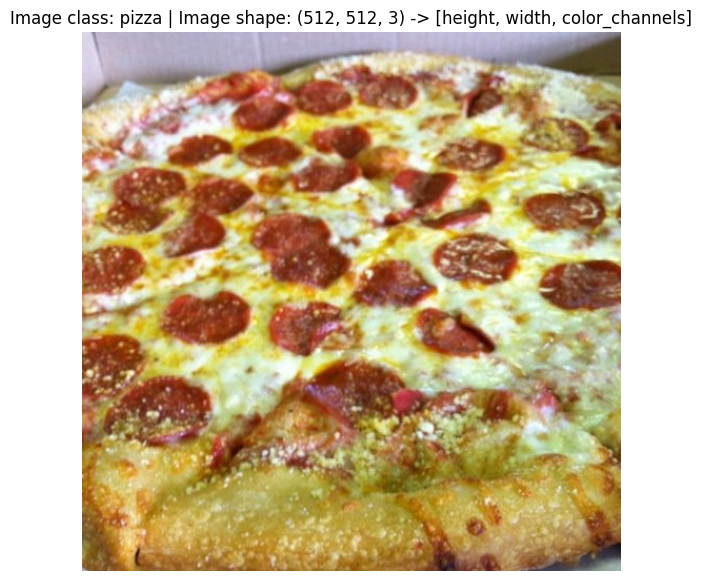

In [20]:
# Visualise the image with `matplotlib.pyplot.imshow()`

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Helper Functions

### Prepare the data for training and testing image classification models.

Do so using PyTorch Datasets and Dataloaders for each training and testing data

#### PyTorch Dataset (specifically, `datasets.ImageFolder`)
**Why?**
- knows at which file path the data can be found (images have been pre-organised in folders corresponding to the classnames)
- able to fetch required images from their correct locations accordingly
- apply input transformations to each image before fetching it


#### PyTorch Dataloader
**Why?**
- returns `batch_size` number of items from the `Dataset` together <br/>

**Configurations:**
- shuffle training data every epoch so model does not learn the order of data (using `shuffle=True`)
- set up parallel processing by using multiple "workers" (`num_workers`) to load data while model is processing current batch
- `pin_memory=True` helps speed up transfer of data from computer's main memory to GPU (if available)
---

In [21]:
# define helper function

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # create Datasets for training and testing data
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # create DataLoaders from the Datasets
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  # Get class names
  class_names = train_data.classes

  return train_dataloader, test_dataloader, class_names

### Train and evaluate a PyTorch model for image classification

In [22]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# train the model for one epoch
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train() # train mode

    # initialise train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through Dataloader data batches
    for batch, (X, y) in enumerate(dataloader):

        # send data to target device
        X, y = X.to(device), y.to(device)

        # do a forward pass to get predictions
        y_pred = model(X)

        # compute the loss
        loss = loss_fn(y_pred, y)

        # clears old gradients
        optimizer.zero_grad()

        # backpropogate
        loss.backward()

        # update the model's weights
        optimizer.step()

        # compute batch accuracy
        # take the class with the highest logit and compare it to the true labels
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

        # accumulate loss and accuracy across batches
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        train_loss += loss.item()

    # return average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


# test the model for one epoch
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval() # eval (testing) mode

    # initialise test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # turn on inference context manager to turn off gradient tracking for speed and memory savings
    with torch.inference_mode():

        # loop through Dataloader data batches
        for batch, (X, y) in enumerate(dataloader):

            # send data to target device
            X, y = X.to(device), y.to(device)

            # forward pass
            test_pred_logits = model(X)

            # calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # return average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
    

In [23]:
from typing import Dict, List
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter
          ) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        # Use the writer parameter to track experiments
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass

    # Return the filled results at the end of the epochs
    return results

### Write to TensorBoard

In [24]:
def create_writer(model_name: str,
                  epoch_number: str) -> torch.utils.tensorboard.writer.SummaryWriter():
    
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    log_dir = os.path.join("runs", timestamp, model_name, epoch_number)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

#### Save a model to a target directory 

In [25]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## Baseline Model: TinyVGG with Data Augmentation

### Prepare data with transforms

In [26]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

num_classes = len(train_data_augmented.classes)

# Turn Datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_tinyvgg = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_tinyvgg = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_tinyvgg, test_tinyvgg

(<torch.utils.data.dataloader.DataLoader at 0x798763ac7dd0>,
 <torch.utils.data.dataloader.DataLoader at 0x79877369c710>)

### Construct model

In [27]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [30]:
def create_tinyvgg(
    input_shape: int = 3,
    hidden_units: int = 10,
    out_features: int = num_classes
):
    # 1) Set seeds (optional)
    set_seeds()

    # 2) Build model and move to device
    model = TinyVGG(
        input_shape=input_shape,
        hidden_units=hidden_units,
        output_shape=out_features
    ).to(device)

    # 3) Name it (for logging)
    model.name = "tinyvgg"
    print(f"[INFO] Created new {model.name} model.")
    return model

## Transfer Learning

### Pretrained Model 1. [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html).

The architecture is from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)

In [31]:
# get the best available pre-trained weights for EfficientNet-B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# load the model with those weights, and move it to chosen device
model_effnetb0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 97.2MB/s]


#### Prepare the data

In [32]:
# get transforms that were used to obtain the weights
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# create data loaders
train_effnetb0, test_effnetb0, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_effnetb0, test_effnetb0, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7988af4cf9d0>,
 ['pizza', 'steak', 'sushi'])

#### Create EffNetB0 Feature Extractor Model

Create a helper function to:
1. Get the base model from `torchvision.models`
2. Freeze the base layers in the model (set `requires_grad=False`)
3. Set the random seeds
4. Change the classifier head (to suit our problem)
5. Give the model a name ("effnetb0" for EffNetB0)

In [33]:
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

### Pretrained Model 2. [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html).

In [34]:
# get the best available pre-trained weights for EfficientNet-B2
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# load the model with those weights, and move it to chosen device
model_effnetb2 = torchvision.models.efficientnet_b2(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 70.7MB/s]


#### Prepare the data

In [35]:
# get transforms that were used to obtain the weights
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# create data loaders
train_effnetb2, test_effnetb2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_effnetb2, test_effnetb2, class_names

Automatically created transforms: ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7987606e8b50>,
 ['pizza', 'steak', 'sushi'])

#### Create EffnetB2 Feature Extractor Model

In [36]:
# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    print("heya")

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

### Pretrained Model 3: [`torchvision.models.vit_b_16`](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html)

In [37]:
# get the best available pre-trained weights for ViT-B/16
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# load the model with those weights, and move it to chosen device
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 136MB/s]  


#### Prepare the data

In [44]:
# get transforms that were used to obtain the weights

manual_224 = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_vitb16, test_vitb16, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_224,
    batch_size=32
)

train_vitb16, test_vitb16, class_names

(<torch.utils.data.dataloader.DataLoader at 0x798760653650>,
 ['pizza', 'steak', 'sushi'])

#### Create ViT-B/16 Feature Extractor Model

In [39]:
# Create a ViT-B/16 feature extractor
def create_vitb16():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    # 2. Freeze the base model layers
    for parameter in pretrained_vit.parameters():
        parameter.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

    # 5. Give the model a name
    model.name = "vitb16"
    print(f"[INFO] Created new {model.name} model.")
    return model

## Create experiments and set up training code

In [45]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create a dictionary linking the models to their respective train and test dataloaders
models = {
    "vitb16": {
        "function": create_vitb16, 
        "train": train_vitb16,
        "test": test_vitb16,
    },
    "effnetb2": {
        "function": create_effnetb2, 
        "train": train_effnetb2,
        "test": test_effnetb2,
    },
    "tinyvgg": {
        "function": create_tinyvgg,
        "train": train_tinyvgg,
        "test": test_tinyvgg
    },    
    "effnetb0": {
        "function": create_effnetb0, 
        "train": train_effnetb0,
        "test": test_effnetb0,
    }
}

In [46]:
%%time

set_seeds(seed=42)

experiment_number = 0

for epochs in num_epochs:
    for model_name, cfg in models.items():
        experiment_number += 1
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] Number of epochs: {epochs}")

        # Build a fresh model
        model = cfg["function"]()  # call the factory to get a new model

        # Get the dataloaders
        train_dataloader = cfg["train"]
        test_dataloader = cfg["test"]

        # Fresh loss/optimizer per run
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        # Train
        train(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(model_name=model_name, epoch_number=f"{epochs}_epochs")
        )

        # Save (removed undefined dataloader_name)
        save_filepath = f"07_{model_name}_{epochs}_epochs.pth"
        save_model(model=model, target_dir="models", model_name=save_filepath)
        print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: vitb16
[INFO] Number of epochs: 5
[INFO] Created new vitb16 model.
[INFO] Created SummaryWriter, saving to: runs/2025-08-12/vitb16/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0458 | train_acc: 0.2461 | test_loss: 1.5671 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.2927 | train_acc: 0.2852 | test_loss: 1.0701 | test_acc: 0.5114
Epoch: 3 | train_loss: 1.1223 | train_acc: 0.3398 | test_loss: 1.4860 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1800 | train_acc: 0.3281 | test_loss: 1.2393 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.4098 | train_acc: 0.3555 | test_loss: 1.1029 | test_acc: 0.4214
[INFO] Saving model to: models/07_vitb16_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] Number of epochs: 5
heya
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-08-12/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0888 | train_acc: 0.3867 | test_loss: 0.9322 | test_acc: 0.7434
Epoch: 2 | train_loss: 0.8543 | train_acc: 0.8516 | test_loss: 0.8664 | test_acc: 0.7538
Epoch: 3 | train_loss: 0.7999 | train_acc: 0.7148 | test_loss: 0.7807 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.6802 | train_acc: 0.8008 | test_loss: 0.7134 | test_acc: 0.8362
Epoch: 5 | train_loss: 0.5987 | train_acc: 0.9141 | test_loss: 0.6669 | test_acc: 0.8362
[INFO] Saving model to: models/07_effnetb2_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: tinyvgg
[INFO] Number of epochs: 5
[INFO] Created new tinyvgg model.
[INFO] Created SummaryWriter, saving to: runs/2025-08-12/tinyvgg/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1079 | train_acc: 0.2578 | test_loss: 1.1375 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0827 | train_acc: 0.4258 | test_loss: 1.1667 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1210 | train_acc: 0.2930 | test_loss: 1.1724 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0961 | train_acc: 0.4141 | test_loss: 1.1393 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0943 | train_acc: 0.2930 | test_loss: 1.1442 | test_acc: 0.2083
[INFO] Saving model to: models/07_tinyvgg_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb0
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-08-12/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0552 | train_acc: 0.4805 | test_loss: 0.8709 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.8930 | train_acc: 0.6133 | test_loss: 0.8002 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.8017 | train_acc: 0.7148 | test_loss: 0.6766 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7204 | train_acc: 0.7383 | test_loss: 0.6337 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6434 | train_acc: 0.7695 | test_loss: 0.6318 | test_acc: 0.8352
[INFO] Saving model to: models/07_effnetb0_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: vitb16
[INFO] Number of epochs: 10
[INFO] Created new vitb16 model.
[INFO] Created SummaryWriter, saving to: runs/2025-08-12/vitb16/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0458 | train_acc: 0.2461 | test_loss: 1.5671 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.2927 | train_acc: 0.2852 | test_loss: 1.0701 | test_acc: 0.5114
Epoch: 3 | train_loss: 1.1223 | train_acc: 0.3398 | test_loss: 1.4860 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1800 | train_acc: 0.3281 | test_loss: 1.2393 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.4098 | train_acc: 0.3555 | test_loss: 1.1029 | test_acc: 0.4214
Epoch: 6 | train_loss: 1.0047 | train_acc: 0.5352 | test_loss: 1.1644 | test_acc: 0.2812
Epoch: 7 | train_loss: 1.0101 | train_acc: 0.4844 | test_loss: 1.2613 | test_acc: 0.2292
Epoch: 8 | train_loss: 1.0748 | train_acc: 0.4141 | test_loss: 1.0868 | test_acc: 0.4119
Epoch: 9 | train_loss: 0.8980 | train_acc: 0.5742 | test_loss: 1.2859 | test_acc: 0.2812
Epoch: 10 | train_loss: 1.1582 | train_acc: 0.4141 | test_loss: 1.2008 | test_acc: 0.3542
[INFO] Saving model to: models/07_vitb16_10_epochs.pth
--------------------------------------------------

[I

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0888 | train_acc: 0.3867 | test_loss: 0.9322 | test_acc: 0.7434
Epoch: 2 | train_loss: 0.8543 | train_acc: 0.8516 | test_loss: 0.8664 | test_acc: 0.7538
Epoch: 3 | train_loss: 0.7999 | train_acc: 0.7148 | test_loss: 0.7807 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.6802 | train_acc: 0.8008 | test_loss: 0.7134 | test_acc: 0.8362
Epoch: 5 | train_loss: 0.5987 | train_acc: 0.9141 | test_loss: 0.6669 | test_acc: 0.8362
Epoch: 6 | train_loss: 0.6105 | train_acc: 0.8047 | test_loss: 0.6050 | test_acc: 0.8362
Epoch: 7 | train_loss: 0.5508 | train_acc: 0.8164 | test_loss: 0.5591 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.4706 | train_acc: 0.9570 | test_loss: 0.5431 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.4723 | train_acc: 0.8359 | test_loss: 0.5225 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.4097 | train_acc: 0.9727 | test_loss: 0.5136 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_10_epochs.pth
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1079 | train_acc: 0.2578 | test_loss: 1.1375 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0827 | train_acc: 0.4258 | test_loss: 1.1667 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1210 | train_acc: 0.2930 | test_loss: 1.1724 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0961 | train_acc: 0.4141 | test_loss: 1.1393 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0943 | train_acc: 0.2930 | test_loss: 1.1442 | test_acc: 0.2083
Epoch: 6 | train_loss: 1.0979 | train_acc: 0.3164 | test_loss: 1.1515 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1137 | train_acc: 0.3203 | test_loss: 1.1356 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0944 | train_acc: 0.3633 | test_loss: 1.1002 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.0855 | train_acc: 0.5352 | test_loss: 1.0751 | test_acc: 0.5938
Epoch: 10 | train_loss: 1.0677 | train_acc: 0.4492 | test_loss: 1.0484 | test_acc: 0.5625
[INFO] Saving model to: models/07_tinyvgg_10_epochs.pth
--------------------------------------------------

[

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0552 | train_acc: 0.4805 | test_loss: 0.8709 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.8930 | train_acc: 0.6133 | test_loss: 0.8002 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.8017 | train_acc: 0.7148 | test_loss: 0.6766 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7204 | train_acc: 0.7383 | test_loss: 0.6337 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6434 | train_acc: 0.7695 | test_loss: 0.6318 | test_acc: 0.8352
Epoch: 6 | train_loss: 0.5703 | train_acc: 0.7969 | test_loss: 0.5895 | test_acc: 0.8352
Epoch: 7 | train_loss: 0.5910 | train_acc: 0.7969 | test_loss: 0.5566 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5358 | train_acc: 0.7969 | test_loss: 0.4820 | test_acc: 0.9167
Epoch: 9 | train_loss: 0.4827 | train_acc: 0.8047 | test_loss: 0.4733 | test_acc: 0.8561
Epoch: 10 | train_loss: 0.4918 | train_acc: 0.8359 | test_loss: 0.5293 | test_acc: 0.7945
[INFO] Saving model to: models/07_effnetb0_10_epochs.pth
--------------------------------------------------



#### Model Training Results Evaluation

| Experiment | Model    | Epochs | Best Test Accuracy   | Test Loss at Best Accuracy |
|------------|----------|--------|---------------------|----------------------------|
| 1          | vitb16   | 5      | 0.5114 (Epoch 2)    | 1.0701                     |
| 2          | effnetb2 | 5      | 0.8362 (Epoch 4-5)  | 0.6669                     |
| 3          | tinyvgg  | 5      | 0.2604 (Epoch 1)    | 1.1375                     |
| 4          | effnetb0 | 5      | 0.8864 (Epoch 3-4)  | 0.6337                     |
| 5          | vitb16   | 10     | 0.5114 (Epoch 2)    | 1.0701                     |
| 6          | effnetb2 | 10     | 0.8977 (Epoch 9)    | 0.5225                     |
| 7          | tinyvgg  | 10     | 0.5938 (Epoch 9)    | 1.0751                     |
| 8          | effnetb0 | 10     | 0.9167 (Epoch 8)    | 0.4820                     |

**Conclusion** <br />
The best performing model is EfficientNet-B0 trained for 10 epochs (Experiment 8), achieving the highest test accuracy of 91.67% at epoch 8 with the lowest test loss of 0.4820. This indicates strong generalization and effective learning on the dataset.

Other models such as EfficientNet-B2 also performed well but did not surpass EfficientNet-B0’s accuracy. Vision Transformer (vitb16) and TinyVGG models showed lower accuracy, suggesting less effective learning under the current training conditions.

Therefore, the EfficientNet-B0 model at epoch 8 is selected as the best model for this task.

### View experiments in TensorBoard

In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

## Load in the best model and make predictions with it

In [64]:
best_model_path = "models/07_effnetb0_10_epochs.pth"

best_model = create_effnetb0()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

In [66]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB0 feature extractor model size: {effnetb0_model_size} MB")

EfficientNetB0 feature extractor model size: 15 MB


### Predict on the test dataset

In [67]:
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    model.to(device)

    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

In [ ]:
# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

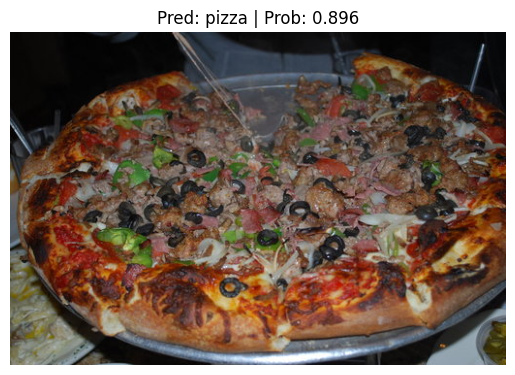

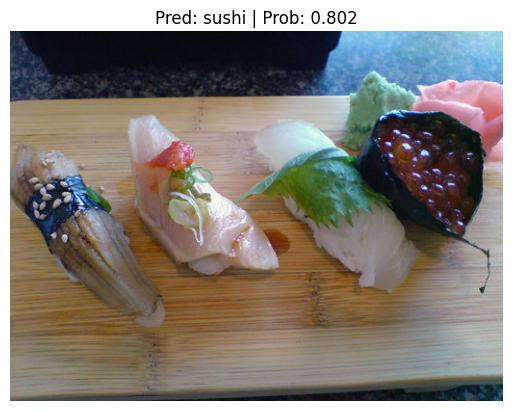

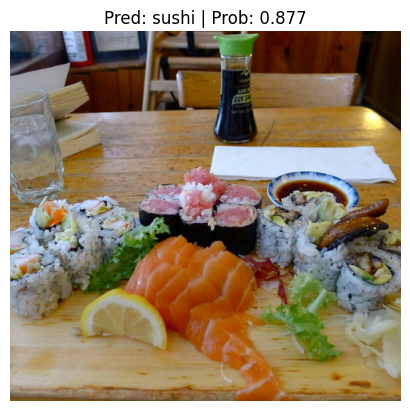

In [70]:
from pathlib import Path
import random

num_images_to_plot = 3
test_dir = Path("data/pizza_steak_sushi") / "test"  # Correct path joining
test_image_path_list = list(test_dir.glob("*/*.jpg"))  # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

# Then your loop...
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))